In [1]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

--2021-05-31 17:09:36--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 827012 (808K) [text/plain]
Saving to: ‘eng.testa.1’

eng.testa.1         100%[===================>] 807.63K  --.-KB/s    in 0.05s   

2021-05-31 17:09:36 (17.5 MB/s) - ‘eng.testa.1’ saved [827012/827012]

--2021-05-31 17:09:36--  https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281528 (3.1M) [text/plai

In [2]:
!head eng.train

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [3]:
# !pip install transformers

     |████████████████████████████████| 2.3MB 8.1MB/s 
     |████████████████████████████████| 3.3MB 46.3MB/s 
     |████████████████████████████████| 901kB 49.3MB/s 


In [4]:
from torch.utils.data import Dataset, DataLoader
from typing import List
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import notebook
from torch import nn
from sklearn.metrics import classification_report
import torch
import transformers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import seaborn as sns
import numpy as np
import pandas as pd

In [5]:
def read_data(file):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in notebook.tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


train = read_data("eng.train")
valid = read_data("eng.testa")

In [6]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [7]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

In [8]:
def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)

In [9]:
def get_sent_length_distribution(sentences):
  sentences = [len(length_per_sent) for length_per_sent in sentences]
  return Counter(sentences)

In [10]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

In [11]:
length_train_distr = get_sent_length_distribution(train['sentences'])
length_valid_distr = get_sent_length_distribution(valid['sentences'])

Train distribution


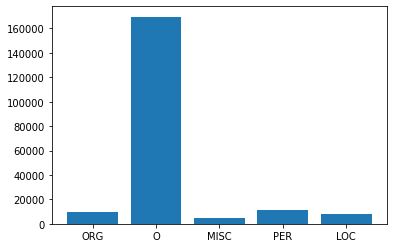

Valid distribution


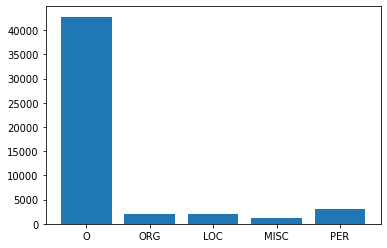

Train distribution


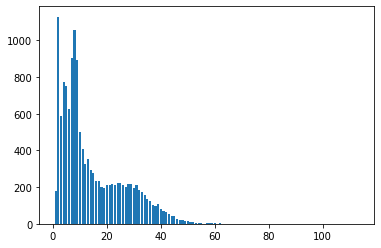

Valid distribution


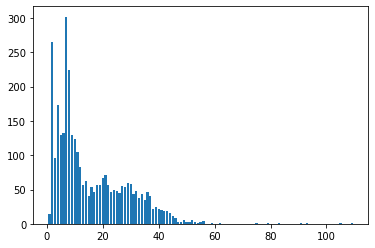

In [12]:
def visualize_distr(data: Counter):
  labels = list(data.keys())
  plt.bar(x=labels, height=list(data.values()))
  plt.show()


print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)
print('Train distribution')
visualize_distr(length_train_distr)
print("Valid distribution")
visualize_distr(length_valid_distr)

In [13]:
config = {
    "MAX_LEN": 128,
    "EPOCHS": 10,
    "TOKENIZER": transformers.BertTokenizer.from_pretrained(
    "bert-base-uncased", do_lower_case=True),
    "MODEL_PATH": "model.bin",
    "NUM_LABELS": len(list(train_distribution.keys())),
    "TRAIN_BATCH_SIZE": 32,
    "VALID_BATCH_SIZE": 32
}

label_str_to_id = {'O':0, 
                   'LOC':1, 
                   'PER':2, 
                   'MISC':3, 
                   'ORG':4}

label_id_to_str = {0:"O", 
                   1:'LOC', 
                   2:"PER", 
                   3:"MISC", 
                   4:"ORG"}

In [14]:
def label_str_to_id_func(data):
    for idx, labels in enumerate(data['labels_per_sent']):
        data['labels_per_sent'][idx] = list(map(lambda x: label_str_to_id[x], data['labels_per_sent'][idx]))
    return data

train = label_str_to_id_func(train)
valid = label_str_to_id_func(valid)

In [15]:
class NERDataset(Dataset):
  def __init__(self, data):
    super(NERDataset, self).__init__()
    self.data = data
    self.texts = self.data["sentences"]
    self.labels = self.data["labels_per_sent"]
  
  def __len__(self):
    return len(self.texts)

  def __getitem__(self, index):    
      text = self.texts[index]
      label = self.labels[index]
      
      ids = []
      target_label = []

      for i, s in enumerate(text):
          inputs = config["TOKENIZER"].encode(s, add_special_tokens=False)
          input_len = len(inputs)
          ids.extend(inputs)
          target_label.extend([label[i]] * input_len)
      
      ids = ids[:config["MAX_LEN"] - 2]
      len_word = len(ids)
      target_label = target_label[:config["MAX_LEN"] - 2]

      ids = [101] + ids + [102]
      target_label = [0] + target_label + [0]

      mask = [1] * len(ids)
      token_type_ids = [0] * len(ids)


      padding_len = config["MAX_LEN"] - len(ids)
      ids = ids + ([0] * padding_len)
      mask = mask + ([0] * padding_len)
      token_type_ids = token_type_ids + ([0] * padding_len)
      target_label = target_label + ([0] * padding_len)

      return {"ids": torch.tensor(ids, dtype=torch.long),
              "mask": torch.tensor(mask, dtype=torch.long),
              "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
              "labels": torch.tensor(target_label, dtype=torch.long),
              "len_word": torch.tensor(len_word, dtype=torch.long)
              }

train_dataset = NERDataset(train)
valid_dataset = NERDataset(valid)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=config["TRAIN_BATCH_SIZE"], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=config["VALID_BATCH_SIZE"], shuffle=True)

In [17]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss

In [18]:
class NERModel(nn.Module):
    def __init__(self, num_labels):
        super(NERModel, self).__init__()
        self.num_labels = num_labels
        self.bert = transformers.BertModel.from_pretrained("bert-base-uncased", return_dict=False)
        self.bert_drop = nn.Dropout(0.3)
        self.out_label = nn.Linear(768, self.num_labels)
    
    def forward(self, ids, mask, token_type_ids, labels):
        o1, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)

        bo_label = self.bert_drop(o1)
        label = self.out_label(bo_label)
        loss = loss_fn(label, labels, mask, self.num_labels)

        return loss, label

In [19]:
device = "cuda:0"

In [20]:
model = NERModel(config["NUM_LABELS"])
# model.load_state_dict(torch.load(config['MODEL_PATH']))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
def transform_logits(predictions: List[torch.tensor], words_len):
  soft = torch.nn.Softmax(dim=-1)
  predictions = np.array([sent[1:words_len[idx]+1] for idx, sent in enumerate(predictions)])
  predictions = [soft(word).detach().cpu().numpy() for sent in predictions for word in sent]
  predictions = np.argmax(predictions, axis=-1).tolist()
  return predictions
def transform_target(target_labels: List[torch.tensor], words_len):
  target_labels = target_labels.detach().cpu().numpy()
  labels = []   
  for i, sent in enumerate(target_labels):
      labels.extend(sent[1:words_len[i]+1])
  return labels

In [22]:
# def count_metrics(gold_labels_per_sentence: List[List[str]], predict_labels_per_sentence: List[List[str]]):
#   gold_labels = [l for l_per_sent in gold_labels_per_sentence for l in l_per_sent]
#   predict_labels = [l for l_per_sent in predict_labels_per_sentence for l in l_per_sent]
#   print(classification_report(gold_labels, predict_labels))

In [23]:
def count_metrics(gold_labels, predict_labels): 
    print(classification_report(gold_labels, predict_labels))

In [24]:
#initializing optimizing parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.001,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

In [25]:
#initializing optimizer and scheduler
num_train_steps = int(len(train["sentences"]) / config["TRAIN_BATCH_SIZE"] * config["EPOCHS"])
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

In [26]:
#TRAINING LOOP
losses = {"train_losses": [], "valid_losses": []}
# best_loss = np.inf
for epoch in range(config["EPOCHS"]):
  print()
  print(f"Start eposh #{epoch}")

  model.train()
  final_train_loss = 0
  for train_batch in notebook.tqdm(train_dataloader, total=len(train_dataloader)):    
    for k, v in train_batch.items():
      train_batch[k] = v.to(device)

    optimizer.zero_grad()
    loss, logits = model.forward(train_batch['ids'], train_batch['mask'], train_batch['token_type_ids'], train_batch['labels'])
    losses["train_losses"].append(loss.item())      
    loss.backward()
    optimizer.step()
    scheduler.step()

    final_train_loss += loss.item() 
  print()
  print(f'LOSS: {final_train_loss/len(train_dataloader)}; ----------- EPOSH: {epoch}; ---------- TRAINING')

  predict_labels, gold_labels = [], []

  final_valid_loss = 0
  model.eval()
  for valid_batch in notebook.tqdm(valid_dataloader, total=len(valid_dataloader)):
    for k, v in valid_batch.items():
      valid_batch[k] = v.to(device)
    loss, logits = model.forward(valid_batch['ids'], valid_batch['mask'], valid_batch['token_type_ids'], valid_batch['labels'])
    final_valid_loss += loss.item()
    losses["valid_losses"].append(loss.item())
    gold_labels.extend(transform_target(valid_batch["labels"], valid_batch['len_word']))
    predict_labels.extend(transform_logits(logits, valid_batch['len_word']))
    
  print()
  print(f'LOSS: {final_valid_loss/len(valid_dataloader)}; ----------- EPOSH: {epoch}; ---------- VALIDATING')
  print('-------------------------------------------------')
  count_metrics(gold_labels, predict_labels)  
  print('-------------------------------------------------')
#   if best_loss < final_valid_loss:
#     torch.save(model.state_dict(), config['MODEL_PATH'])
#     best_loss = final_valid_loss


Start eposh #0




LOSS: 0.12574605676101558; ----------- EPOSH: 0; ---------- TRAINING




LOSS: 0.04842042038217187; ----------- EPOSH: 0; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49658
           1       0.97      0.96      0.96      2899
           2       0.99      0.99      0.99      5786
           3       0.87      0.85      0.86      1621
           4       0.91      0.92      0.91      2956

    accuracy                           0.98     62920
   macro avg       0.95      0.94      0.94     62920
weighted avg       0.98      0.98      0.98     62920

-------------------------------------------------

Start eposh #1




LOSS: 0.034444721511635155; ----------- EPOSH: 1; ---------- TRAINING




LOSS: 0.04485197861076278; ----------- EPOSH: 1; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49658
           1       0.96      0.97      0.97      2899
           2       1.00      0.98      0.99      5786
           3       0.87      0.88      0.88      1621
           4       0.90      0.93      0.92      2956

    accuracy                           0.99     62920
   macro avg       0.95      0.95      0.95     62920
weighted avg       0.99      0.99      0.99     62920

-------------------------------------------------

Start eposh #2




LOSS: 0.019869627798313447; ----------- EPOSH: 2; ---------- TRAINING




LOSS: 0.04556662253419157; ----------- EPOSH: 2; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     49658
           1       0.97      0.96      0.96      2899
           2       0.99      0.99      0.99      5786
           3       0.88      0.89      0.88      1621
           4       0.93      0.93      0.93      2956

    accuracy                           0.99     62920
   macro avg       0.95      0.95      0.95     62920
weighted avg       0.99      0.99      0.99     62920

-------------------------------------------------

Start eposh #3




LOSS: 0.01273876059548993; ----------- EPOSH: 3; ---------- TRAINING




LOSS: 0.051030968482533065; ----------- EPOSH: 3; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49658
           1       0.97      0.97      0.97      2899
           2       0.99      0.98      0.99      5786
           3       0.90      0.88      0.89      1621
           4       0.91      0.94      0.92      2956

    accuracy                           0.99     62920
   macro avg       0.95      0.95      0.95     62920
weighted avg       0.99      0.99      0.99     62920

-------------------------------------------------

Start eposh #4




LOSS: 0.008855520181701538; ----------- EPOSH: 4; ---------- TRAINING




LOSS: 0.0503486513414685; ----------- EPOSH: 4; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     49658
           1       0.96      0.97      0.97      2899
           2       0.99      0.99      0.99      5786
           3       0.87      0.90      0.88      1621
           4       0.93      0.93      0.93      2956

    accuracy                           0.99     62920
   macro avg       0.95      0.96      0.95     62920
weighted avg       0.99      0.99      0.99     62920

-------------------------------------------------

Start eposh #5




LOSS: 0.0061496536914102205; ----------- EPOSH: 5; ---------- TRAINING




LOSS: 0.055532264947211; ----------- EPOSH: 5; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49658
           1       0.96      0.97      0.97      2899
           2       0.99      0.99      0.99      5786
           3       0.92      0.88      0.90      1621
           4       0.92      0.94      0.93      2956

    accuracy                           0.99     62920
   macro avg       0.96      0.96      0.96     62920
weighted avg       0.99      0.99      0.99     62920

-------------------------------------------------

Start eposh #6




LOSS: 0.004660687855312788; ----------- EPOSH: 6; ---------- TRAINING




LOSS: 0.05412693616794879; ----------- EPOSH: 6; ---------- VALIDATING
-------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49658
           1       0.96      0.97      0.97      2899
           2       0.99      0.99      0.99      5786
           3       0.92      0.87      0.90      1621
           4       0.92      0.94      0.93      2956

    accuracy                           0.99     62920
   macro avg       0.96      0.95      0.96     62920
weighted avg       0.99      0.99      0.99     62920

-------------------------------------------------

Start eposh #7


KeyboardInterrupt: ignored

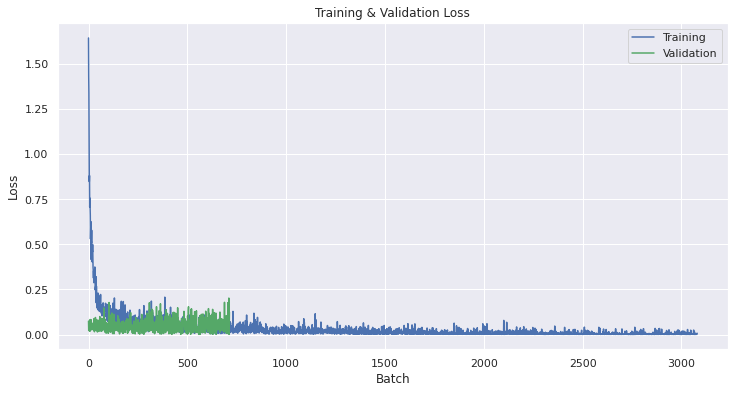

In [27]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(losses['train_losses'], 'b-', label="Training")
plt.plot(losses['valid_losses'], 'g-', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [29]:
#PREDICTING 
sentence = """
     later in his career and since leaving day-to-day operations at microsoft in 2008, gates has pursued many business and philanthropic endeavors
    """

tokenized_sentence = config['TOKENIZER'].encode(sentence)
untokenized_sentence = config['TOKENIZER'].convert_ids_to_tokens(tokenized_sentence)
print(sentence)
sentence = sentence.split()
print(tokenized_sentence)
print(untokenized_sentence)

data = {"sentences":[sentence], "labels_per_sent": [['O'] * len(sentence)]}
data = label_str_to_id_func(data)
test_dataset = NERDataset(data)

# device = torch.device("cuda")
# model = NERModel(config['NUM_LABELS'])
# model.load_state_dict(torch.load(config['MODEL_PATH']))
# model.to(device)

with torch.no_grad():
    data = test_dataset[0]
    for k, v in data.items():
        data[k] = v.to(device).unsqueeze(0)
    _, label = model(data["ids"], data['mask'], data['token_type_ids'], data['labels'])

    label = list(label.argmax(2).cpu().numpy().reshape(-1)[:len(tokenized_sentence)]) #delete cls/sep tokens
    for index, id in enumerate(label):
        label[index] = label_id_to_str[id]
    print()
    print(pd.DataFrame({"words": untokenized_sentence, "labels": label}))


     later in his career and since leaving day-to-day operations at microsoft in 2008, gates has pursued many business and philanthropic endeavors
    
[101, 2101, 1999, 2010, 2476, 1998, 2144, 2975, 2154, 1011, 2000, 1011, 2154, 3136, 2012, 7513, 1999, 2263, 1010, 6733, 2038, 9505, 2116, 2449, 1998, 25321, 28809, 102]
['[CLS]', 'later', 'in', 'his', 'career', 'and', 'since', 'leaving', 'day', '-', 'to', '-', 'day', 'operations', 'at', 'microsoft', 'in', '2008', ',', 'gates', 'has', 'pursued', 'many', 'business', 'and', 'philanthropic', 'endeavors', '[SEP]']

            words labels
0           [CLS]      O
1           later      O
2              in      O
3             his      O
4          career      O
5             and      O
6           since      O
7         leaving      O
8             day      O
9               -      O
10             to      O
11              -      O
12            day      O
13     operations      O
14             at      O
15      microsoft    ORG
16      